In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Je me positionne dans mon répertoire de travail personnel
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\" +
         "OpenClassrooms\\github\\" +
         "OpenClassrooms_Ingenieur_Machine_Learning\\" +
         "Catégorisez automatiquement des questions")

# Lecture des fichiers CSV issus du site "Query Stack Overflow"
fichiers_csv = []
for i in range(9):
    df = pd.read_csv('QueryResults_'+ str(i) + '.csv', sep=',',
                     index_col=None, header=0)
    fichiers_csv.append(df)

df = pd.concat(fichiers_csv, axis=0, ignore_index=True)

C:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
print(df.shape)
print(df.columns)
df.head()

(188065, 23)
Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'DeletionDate', 'Score', 'ViewCount', 'Body', 'OwnerUserId',
       'OwnerDisplayName', 'LastEditorUserId', 'LastEditorDisplayName',
       'LastEditDate', 'LastActivityDate', 'Title', 'Tags', 'AnswerCount',
       'CommentCount', 'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate',
       'ContentLicense'],
      dtype='object')


,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate,ContentLicense
0,4,1,7,NaN,2008-07-31 21:42:52,NaN,737,60139,<p>I want to use a <code>Track-Bar</code> to c...,8,...,2021-02-26 03:31:15,2021-02-26 03:31:15,How to convert a Decimal to a Double in C#?,<c#><floating-point><type-conversion><double><...,14,5,57,NaN,2012-10-31 16:42:47,CC BY-SA 4.0
1,6,1,31,NaN,2008-07-31 22:08:08,NaN,309,21903,<p>I have an absolutely positioned <code>div</...,9,...,2021-01-29 18:46:45,2021-01-29 18:46:45,Why did the width collapse in the percentage w...,<html><css><internet-explorer-7>,7,1,12,NaN,NaN,CC BY-SA 4.0
2,9,1,1404,NaN,2008-07-31 23:40:59,NaN,2051,695724,<p>Given a <code>DateTime</code> representing ...,1,...,2021-01-05 17:33:32,2021-09-24 16:38:57,How do I calculate someone's age based on a Da...,<c#><.net><datetime>,67,10,479,NaN,2011-08-16 19:40:43,CC BY-SA 4.0
3,11,1,1248,NaN,2008-07-31 23:55:37,NaN,1591,181198,<p>Given a specific <code>DateTime</code> valu...,1,...,2017-06-04 15:51:19,2021-09-01 21:49:09,Calculate relative time in C#,<c#><datetime><time><datediff><relative-time-s...,40,3,550,NaN,2009-09-04 13:15:59,CC BY-SA 3.0
4,17,1,26,NaN,2008-08-01 05:09:55,NaN,194,81781,"<p>How do I store binary data in <a href=""http...",2,...,2020-12-03 03:37:51,2020-12-03 03:37:51,Binary Data in MySQL,<mysql><database><binary-data><data-storage>,9,3,22,2018-11-29 15:36:04,NaN,CC BY-SA 3.0


On examine les colonnes de dates pour avoir une idée de l'étendue de notre jeu de données

In [3]:
for col in ['CreationDate', 'LastEditDate', 'ClosedDate',
            'LastActivityDate', 'CommunityOwnedDate', 'DeletionDate']:
    print('Nombre de lignes avec une', col, 'nulle:',
          len(df[df[col].isna()]), '/', len(df))

Nombre de lignes avec une CreationDate nulle: 0 / 188065
Nombre de lignes avec une LastEditDate nulle: 6 / 188065
Nombre de lignes avec une ClosedDate nulle: 176231 / 188065
Nombre de lignes avec une LastActivityDate nulle: 0 / 188065
Nombre de lignes avec une CommunityOwnedDate nulle: 186424 / 188065
Nombre de lignes avec une DeletionDate nulle: 188065 / 188065


Je renseigne les LastEditDate manquantes avec la CreationDate.

In [4]:
df.loc[df['LastEditDate'].isna(), 'LastEditDate'] = df['CreationDate']
print('Nombre de lignes avec une LastEditDate nulle:',
      len(df[df['LastEditDate'].isna()]), '/', len(df))

Nombre de lignes avec une LastEditDate nulle: 0 / 188065


In [5]:
df.drop('DeletionDate', axis=1, inplace=True)
print(df.shape)
print(df.columns)

(188065, 22)
Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'ParentId', 'CreationDate',
       'Score', 'ViewCount', 'Body', 'OwnerUserId', 'OwnerDisplayName',
       'LastEditorUserId', 'LastEditorDisplayName', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate', 'ContentLicense'],
      dtype='object')


In [6]:
for col in ['CreationDate', 'LastEditDate', 'LastActivityDate']:
    print(col, 'min :', df[col].min(), '- max :', df[col].max())

CreationDate min : 2008-07-31 21:42:52 - max : 2014-07-28 16:37:26
LastEditDate min : 2008-08-03 21:38:52 - max : 2021-10-02 23:02:32
LastActivityDate min : 2008-09-10 12:02:14 - max : 2021-10-03 04:47:42


In [7]:
print(df['PostTypeId'].unique())

[1]


Je supprime la colonne 'PostTypeId' qui vaut toujours '1'.

In [8]:
df.drop('PostTypeId', axis=1, inplace=True)
print(df.shape)
print(df.columns)

(188065, 21)
Index(['Id', 'AcceptedAnswerId', 'ParentId', 'CreationDate', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'OwnerDisplayName',
       'LastEditorUserId', 'LastEditorDisplayName', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'FavoriteCount', 'ClosedDate', 'CommunityOwnedDate', 'ContentLicense'],
      dtype='object')


In [9]:
print(df['ParentId'].unique())

[nan]


Je supprime la colonne ParentId qui n'est jamais renseignée dans nos données.

In [10]:
df.drop('ParentId', axis=1, inplace=True)
print(df.shape)
print(df.columns)

(188065, 20)
Index(['Id', 'AcceptedAnswerId', 'CreationDate', 'Score', 'ViewCount', 'Body',
       'OwnerUserId', 'OwnerDisplayName', 'LastEditorUserId',
       'LastEditorDisplayName', 'LastEditDate', 'LastActivityDate', 'Title',
       'Tags', 'AnswerCount', 'CommentCount', 'FavoriteCount', 'ClosedDate',
       'CommunityOwnedDate', 'ContentLicense'],
      dtype='object')


In [11]:
print(df['ContentLicense'].unique())

['CC BY-SA 4.0' 'CC BY-SA 3.0' 'CC BY-SA 2.5']


J'examine le taux de remplissage des colonnes restantes.

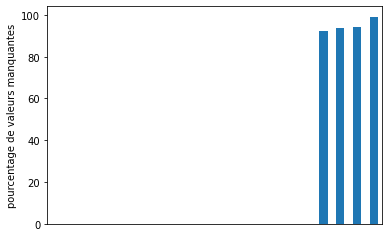

                       pourcentage_manquant
OwnerDisplayName                  92.071890
ClosedDate                        93.707495
LastEditorDisplayName             93.997288
CommunityOwnedDate                99.127429


In [12]:
def show_missing_data(data, pourcentage_manquant):
    percent_missing = data.isnull().sum() * 100 / len(data)
    missing_values = pd.DataFrame({'pourcentage_manquant': percent_missing})
    missing_values.sort_values('pourcentage_manquant', inplace=True)
    ax1 = missing_values["pourcentage_manquant"].plot(kind='bar')
    ax1.xaxis.set_visible(False)
    plt.ylabel("pourcentage de valeurs manquantes")
    plt.show()
    print(missing_values[missing_values["pourcentage_manquant"] > pourcentage_manquant])
    
show_missing_data(df, 1)

Je supprime les 4 colonnes dont le taux de remplissage est inférieur à 10%, les autres colonnes étant très bien renseignées.

In [13]:
df.drop(['OwnerDisplayName', 'ClosedDate',
         'LastEditorDisplayName', 'CommunityOwnedDate'],
        axis=1, inplace=True)
print(df.shape)
print(df.columns)

(188065, 16)
Index(['Id', 'AcceptedAnswerId', 'CreationDate', 'Score', 'ViewCount', 'Body',
       'OwnerUserId', 'LastEditorUserId', 'LastEditDate', 'LastActivityDate',
       'Title', 'Tags', 'AnswerCount', 'CommentCount', 'FavoriteCount',
       'ContentLicense'],
      dtype='object')


J'examine les valeurs numériques et leurs distributions

In [32]:
def show_distribution_col(data, col):
    plt.rcParams['figure.figsize']=(10,6)
    uniques = data[~data[col].isna()][col].unique()
    uniques.sort()
    print(col, ":\n", uniques, "\n")
    if col in ['Score', 'ViewCount', 'CommentCount',
               'FavoriteCount', 'title_len', 'body_len']:
        plt.boxplot(data[col], vert=False, showfliers=False)
        plt.show()
    if col in ['AnswerCount', 'CommentCount', 'ContentLicense',
               'title_len', 'body_len']:
        groups_count = data[~data[col].isna()][col].value_counts(
            normalize=True, sort=False).sort_index(ascending=True)
        groups_count.plot(kind='bar')
        plt.xlabel(col)
        plt.show()
    plt.rcdefaults()

In [ ]:
show_distribution_col(df, 'Score')
show_distribution_col(df, 'ViewCount')
show_distribution_col(df, 'AnswerCount')
show_distribution_col(df, 'CommentCount')
show_distribution_col(df, 'FavoriteCount')
show_distribution_col(df, 'ContentLicense')

J'extrais la liste de tous les tags présents sur les questions pour avoir une idée de leur diversité.

In [15]:
tags = list(map(lambda x: set(re.findall("<(.*?)>", x)), df['Tags']))
tags = sorted(set.union(*tags))
print("Nombre de tags :", len(tags))
print(tags)

Nombre de tags : 18672
['.a', '.app', '.bash-profile', '.class-file', '.doc', '.emf', '.hgtags', '.htaccess', '.htpasswd', '.mov', '.net', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.0-beta-2', '.net-4.5', '.net-4.5.2', '.net-4.6', '.net-assembly', '.net-attributes', '.net-client-profile', '.net-core', '.net-framework-version', '.net-internals', '.net-micro-framework', '.net-reflector', '.net-remoting', '.net-security', '.net-standard', '.obj', '.profile', '.refresh', '.when', '128-bit', '16-bit', '2-digit-year', '2-legged', '2-way-object-databinding', '2048', '256color', '2d', '2d-games', '3-tier', '3-way-merge', '32-bit', '32bit-64bit', '37-signals', '3d', '3d-model', '3d-reconstruction', '3d-rendering', '3des', '3dr', '3ds', '3dsmax', '3g', '3g-network', '3nf', '3scale', '4d-database', '4g', '64-bit', '6502', '68000', '6nf', '7-bit', '7zip', '8-bit', '8051', '960.gs', 'a-records', 'a-star', 'a2dp', 'aabb', 'aac', 'aapt', 'aar', 'aasm', 'ab-testing', 'abaddres

Je convertis la chaine de caractères en liste dans la colonne "Tags"

In [16]:
df['Tags'] = list(map(lambda x: re.findall("<(.*?)>", x), df['Tags']))

Je cherche à observer la distribution des tags, mais avec un grand nombre d'éléments, les traitements prennent du temps.

In [17]:
def get_tags_counts(serie):
    nb_tags = len(serie)
    tags_counts_arr = []
    # je divise les tags en "petites" parties de 10000 éléments
    # pour accélérer le traitement
    step = 10000
    for i in range(0, nb_tags, step):
        if i + step > nb_tags:
            dft = pd.DataFrame(serie[i:].sum()).value_counts()
        else:
            dft = pd.DataFrame(serie[i:i+step].sum()).value_counts()
        tags_counts_arr.append(dft)
    tags_counts = tags_counts_arr[0]
    for i in range(1, len(tags_counts_arr)):
        tags_counts.add(tags_counts_arr[i], fill_value=0)
    return tags_counts

In [18]:
tags_df = pd.DataFrame(get_tags_counts(df['Tags']))
tags_df.rename(columns={0: 'nb'}, inplace=True)
nb_100 = len(tags_df[tags_df['nb'] > 100])
print("Nombre de tags présents + de 100 fois :", nb_100)
print("Nombre de tags présents 1 seule fois :",
      len(tags_df[tags_df['nb'] == 1]))
print("Les", nb_100, "premiers :\n",
      tags_df[tags_df['nb'] > 100].head(nb_100))

Nombre de tags présents + de 100 fois : 41
Nombre de tags présents 1 seule fois : 2269
Les 41 premiers :
                      nb
0                      
c#                 1415
.net               1024
java                897
c++                 685
python              640
javascript          584
sql                 386
php                 368
sql-server          359
asp.net             326
c                   309
html                294
windows             270
visual-studio       244
database            223
ruby                199
jquery              198
language-agnostic   193
css                 188
mysql               187
algorithm           183
linux               181
performance         181
string              178
svn                 169
unit-testing        167
xml                 165
regex               144
version-control     141
wpf                 140
oop                 139
asp.net-mvc         134
iphone              125
winforms            124
multithreading      120
object

On a beaucoup de tags qui se ressemblent (préfixe commun, et une précision sur la version ou le sous-module) : pour réduire la cible, on va unifier ces valeurs.

In [19]:
dot_net_tags = [t for t in tags if t.startswith('.net')]
print(dot_net_tags)
amazon_tags = [t for t in tags if t.startswith('amazon')]
print(amazon_tags)

['.net', '.net-1.1', '.net-2.0', '.net-3.0', '.net-3.5', '.net-4.0', '.net-4.0-beta-2', '.net-4.5', '.net-4.5.2', '.net-4.6', '.net-assembly', '.net-attributes', '.net-client-profile', '.net-core', '.net-framework-version', '.net-internals', '.net-micro-framework', '.net-reflector', '.net-remoting', '.net-security', '.net-standard']
['amazon', 'amazon-ami', 'amazon-appstore', 'amazon-cloudformation', 'amazon-cloudfront', 'amazon-cognito', 'amazon-dynamodb', 'amazon-ebs', 'amazon-ec2', 'amazon-elastic-beanstalk', 'amazon-elasticache', 'amazon-elb', 'amazon-emr', 'amazon-iam', 'amazon-mws', 'amazon-product-api', 'amazon-rds', 'amazon-redshift', 'amazon-route53', 'amazon-s3', 'amazon-ses', 'amazon-simpledb', 'amazon-sns', 'amazon-sqs', 'amazon-swf', 'amazon-vpc', 'amazon-web-services']


Je teste le remplacement par un préfixe sur un sous-ensemble, pour 1 seul préfixe :

In [20]:
prefix = '.net'
print(df['Tags'][20:30])
print(df['Tags'][20:30].apply(lambda liste_tags: [prefix if t.startswith(prefix) else t for t in liste_tags]))

20          [linux, bash, unix, coredump, tcsh]
21                   [version-control, ankhsvn]
22                            [javascript, css]
23            [javascript, validation, numbers]
24           [php, plugins, architecture, hook]
25    [html, forms, form-submit, submit-button]
26                         [c#, linq, .net-3.5]
27                             [linq, .net-3.5]
28           [apache-flex, actionscript-3, air]
29    [plugins, lua, add-on, world-of-warcraft]
Name: Tags, dtype: object
20          [linux, bash, unix, coredump, tcsh]
21                   [version-control, ankhsvn]
22                            [javascript, css]
23            [javascript, validation, numbers]
24           [php, plugins, architecture, hook]
25    [html, forms, form-submit, submit-button]
26                             [c#, linq, .net]
27                                 [linq, .net]
28           [apache-flex, actionscript-3, air]
29    [plugins, lua, add-on, world-of-warcraft]
Name: Tags, dt

Je fais une liste de préfixes à traiter et je généralise le traitement :

In [21]:
df['simple_tags'] = df['Tags']
for prefix in ['.net', 'abstract', 'accessibility', 'actionscript',
               'aggregate', 'amazon', 'android', 'angular', 'apache-commons',
               'asp.net', 'c#', 'c++', 'cakephp', 'cassandra', 'centos',
               'codeigniter', 'coldfusion', 'cordova', 'css', 'datagrid',
               'datetime', 'delphi', 'directx', 'django', 'docker', 'doctrine',
               'dojo', 'drupal', 'dynamics-crm', 'elasticsearch',
               'entity-framework', 'episerver', 'excel', 'exception',
               'expression-blend', 'extjs', 'f#', 'facebook', 'fancybox',
               'fedora', 'firefox', 'firemonkey', 'flash', 'flask', 'fluent',
               'font-awesome', 'fortran', 'g++', 'gcc', 'gd', 'github',
               'glassfish', 'gmail', 'gnome', 'gnu', 'google-analytics',
               'google-api', 'google-apps', 'google-chrome', 'google-cloud',
               'google-maps', 'google-play', 'google-sheets', 'gradle',
               'grails', 'groovy', 'gwt', 'gzip', 'haskell', 'hibernate',
               'html5', 'http-status', 'hudson', 'ibm', 'icloud', 'iis',
               'installshield', 'internet-explorer', 'ios', 'ipython',
               'jasmine', 'jasper', 'java-ee', 'javascript', 'jboss',
               'jenkins', 'jetty', 'jira', 'jmeter', 'jquery', 'jsf', 'jsr',
               'junit','jupyter', 'jvm', 'kdevelop', 'kotlin', 'laravel',
               'liferay', 'linq', 'lisp', 'llvm', 'log4j', 'macos', 'magento',
               'matlab', 'matrix', 'maven', 'mediawiki', 'microsoft', 'mongodb',
               'mongrel', 'mootools', 'moq', 'ms-access', 'msbuild', 'mysql',
               'netbeans', 'nginx', 'nhibernate', 'nio', 'nlog', 'nmock',
               'nunit', 'office', 'ogg', 'opengl', 'openid', 'openlayers',
               'openoffice', 'oracle', 'outlook', 'paypal', 'pdf', 'perl',
               'php', 'playframework', 'postgresql', 'powershell', 'prestashop',
               'pyqt', 'python', 'radix', 'rails', 'razor', 'resharper',
               'restkit', 'restlet', 'retrofit', 'rspec', 'rss', 'ruby',
               'safari', 'samsung', 'scala', 'scorm', 'sencha-touch',
               'sharepoint', 'silverlight', 'sitecore', 'slick', 'socket.io',
               'spring-data', 'spring-security', 'spring-test', 'sql-server',
               'sqlite', 'sse', 'ssms', 'ssrs', 'svg', 'swift', 'symfony',
               'teamcity', 'telerik', 'tinymce', 'tomcat', 'tortoisehg',
               'tridion', 'twitter', 'typo3', 'ubuntu', 'ucs', 'uglifyjs',
               'umbraco', 'visual-c++', 'visual-sourcesafe', 'visual-studio',
               'visual-web-developer', 'webmatrix', 'websphere', 'wicket',
               'windows-7', 'windows-phone', 'windows-server', 'windows-xp',
               'wix', 'wordpress', 'wpf', 'xamarin', 'xcode', 'xmlhttprequest',
               'xna', 'youtube', 'zend-db', 'zsh'
              ]:
    df['simple_tags'] = df['simple_tags'].apply(lambda liste_tags: [
        prefix if t.startswith(prefix) else t for t in liste_tags])

In [22]:
print(df[['Tags', 'simple_tags']])

                                                     Tags  \
0       [c#, floating-point, type-conversion, double, ...   
1                        [html, css, internet-explorer-7]   
2                                    [c#, .net, datetime]   
3       [c#, datetime, time, datediff, relative-time-s...   
4            [mysql, database, binary-data, data-storage]   
...                                                   ...   
188060                               [javascript, jestjs]   
188061  [c#, asp.net-mvc, visual-studio, visual-studio...   
188062                                [javafx, tableview]   
188063  [python, google-analytics, google-analytics-ap...   
188064                            [laravel-4, pagination]   

                                              simple_tags  
0       [c#, floating-point, type-conversion, double, ...  
1                          [html, css, internet-explorer]  
2                                    [c#, .net, datetime]  
3       [c#, datetime, time

Maintenant on doit supprimer les éventuels doublons créés.

In [23]:
df['simple_tags'] = df['simple_tags'].apply(
    lambda liste_tags: list(set(liste_tags)))

In [24]:
print(df[['Tags', 'simple_tags']])

                                                     Tags  \
0       [c#, floating-point, type-conversion, double, ...   
1                        [html, css, internet-explorer-7]   
2                                    [c#, .net, datetime]   
3       [c#, datetime, time, datediff, relative-time-s...   
4            [mysql, database, binary-data, data-storage]   
...                                                   ...   
188060                               [javascript, jestjs]   
188061  [c#, asp.net-mvc, visual-studio, visual-studio...   
188062                                [javafx, tableview]   
188063  [python, google-analytics, google-analytics-ap...   
188064                            [laravel-4, pagination]   

                                              simple_tags  
0       [floating-point, decimal, double, type-convers...  
1                          [css, internet-explorer, html]  
2                                    [datetime, c#, .net]  
3       [datediff, relative

In [25]:
simple_tags = df['simple_tags'].apply(
    lambda liste_tags: set(liste_tags))
simple_tags = sorted(set.union(*simple_tags))
print("Nombre de tags après simplification :", len(simple_tags),
      "(contre", len(tags), "avant)")

Nombre de tags après simplification : 16549 (contre 18672 avant)


In [26]:
simple_tags_counts = get_tags_counts(df['simple_tags'])
simple_tags_df = pd.DataFrame(simple_tags_counts)
simple_tags_df.rename(columns={0: 'nb'}, inplace=True)
nb_100 = len(simple_tags_df[simple_tags_df['nb'] > 100])
print("Nombre de tags présents + de 100 fois :", nb_100)
print("Nombre de tags présents 1 seule fois :", len(simple_tags_df[simple_tags_df['nb'] == 1]))
print("Les", nb_100, "premiers :\n",
      simple_tags_df[simple_tags_df['nb'] > 100].head(nb_100))

Nombre de tags présents + de 100 fois : 41
Nombre de tags présents 1 seule fois : 2129
Les 41 premiers :
                      nb
0                      
c#                 1420
.net               1073
java                897
c++                 692
python              642
javascript          584
asp.net             429
sql-server          398
sql                 386
php                 372
c                   309
visual-studio       298
html                294
windows             270
ruby                236
database            223
jquery              198
css                 193
language-agnostic   193
mysql               187
algorithm           183
performance         181
linux               181
string              178
svn                 169
unit-testing        167
xml                 165
regex               144
version-control     141
wpf                 140
oop                 139
iphone              125
winforms            124
multithreading      120
objective-c         116
perl  

In [27]:
print(df.columns)

Index(['Id', 'AcceptedAnswerId', 'CreationDate', 'Score', 'ViewCount', 'Body',
       'OwnerUserId', 'LastEditorUserId', 'LastEditDate', 'LastActivityDate',
       'Title', 'Tags', 'AnswerCount', 'CommentCount', 'FavoriteCount',
       'ContentLicense', 'simple_tags'],
      dtype='object')


title_len :
 [ 10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27
  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45
  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150] 



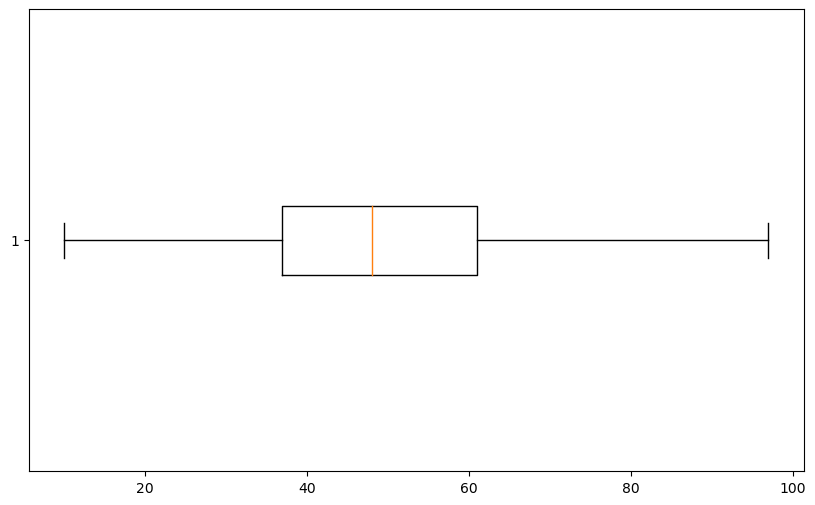

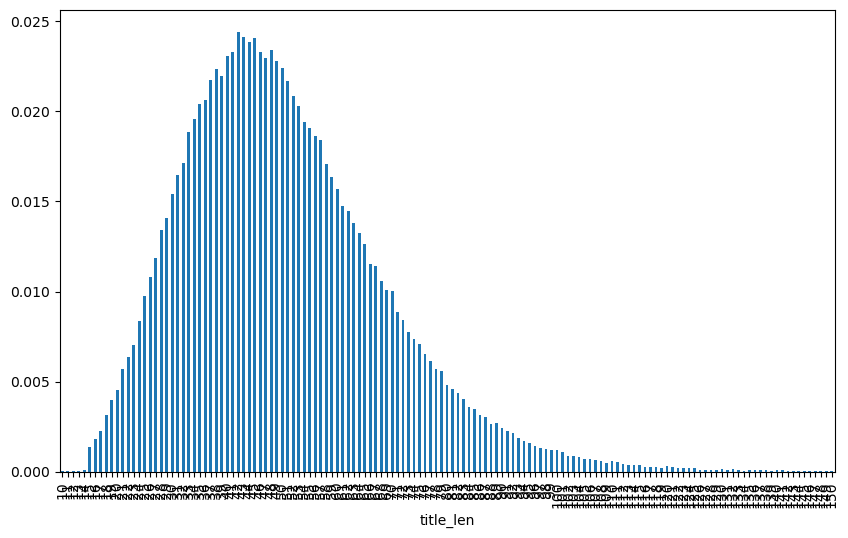

body_len :
 [   25    28    29 ... 29516 30495 37279] 



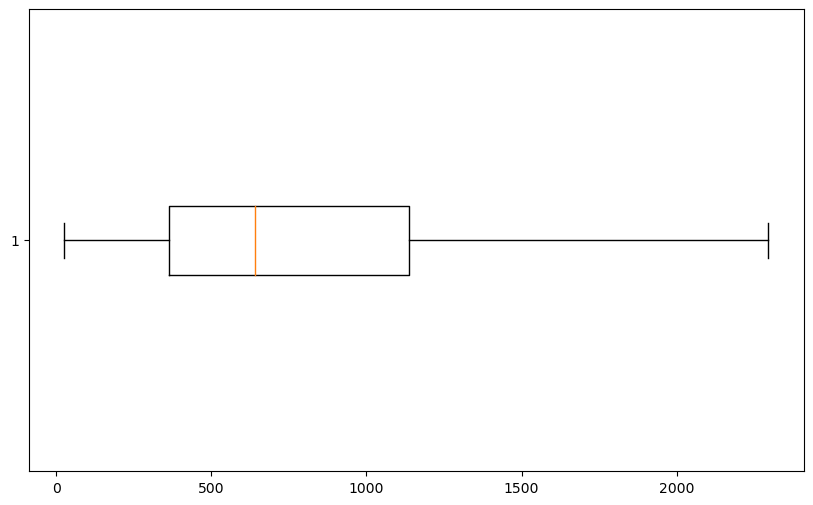

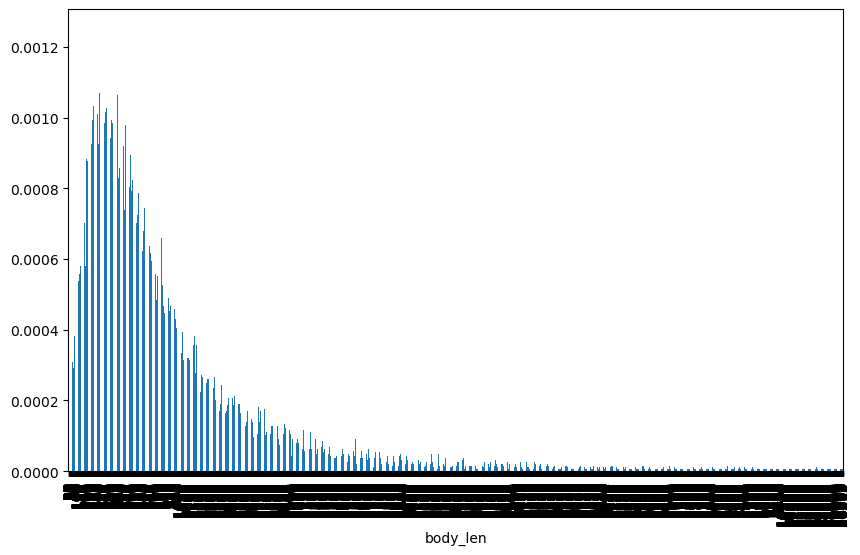

In [33]:
df['title_len'] = df['Title'].apply(lambda title: len(title))
df['body_len'] = df['Body'].apply(lambda body: len(body))
show_distribution_col(df, 'title_len')
show_distribution_col(df, 'body_len')